In [4]:
import os
import copy
import random
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import logging
import glob
import torch.nn.functional as F
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import pandas as pd
from PIL import Image
from torchsummary import summary   

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 4"

In [5]:
# parser = argparse.ArgumentParser()
# args = parser.parse_args()
epochs = 300
batch_size = 64
image_size = 32
num_classes = 10
ckpt_path = "./DDPM/models/"
output_path = "./DDPM/output"
os.makedirs(output_path, exist_ok=True)
mnist_data = "/data/dlcv/hw2/hw2_data/digits/mnistm/data"
mnist_label = "/data/dlcv/hw2/hw2_data/digits/mnistm/train.csv"
mnist_valid = "/data/dlcv/hw2/hw2_data/digits/mnistm/val.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device used:', device)
lr = 3e-4

Device used: cuda


In [6]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [7]:
class digitsDataset(Dataset):
    def __init__(self, inputPath, labelPath, resize=32):
        self.inputPath = inputPath
        
        self.transform = transforms.Compose([
            transforms.Resize((resize,resize)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        self.pd = pd.read_csv(labelPath)
        self.csv = [(name, label) for (name, label) in zip(self.pd['image_name'], self.pd['label'])]
        
    def __getitem__(self, index):
        inputImage = Image.open(os.path.join(self.inputPath, self.csv[index][0]))
        label = int(self.csv[index][1])
        inputImage = self.transform(inputImage)
        
        return inputImage, label        
        
    def __len__(self):
        return len(self.csv)

In [8]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0
        
    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)
            
    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class UNet_conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32//2)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16//2)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8//2)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16//2)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32//2)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64//2)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        # print("t: ", t.shape)
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)
        # print("y: ", y.shape)
        # print("t: ", t.shape)
        # print("x: ", x.shape)
        x1 = self.inc(x)
        # print("x1_inc: ", x1.shape)
        x2 = self.down1(x1, t)
        # print("x2_down1: ", x2.shape)
        x2 = self.sa1(x2)
        # print("x2_sa1: ", x2.shape)
        x3 = self.down2(x2, t)
        # print("x3_down2: ", x3.shape)
        x3 = self.sa2(x3)
        # print("x3_sa2: ", x3.shape)
        x4 = self.down3(x3, t)
        # print("x4_down3: ", x4.shape)
        x4 = self.sa3(x4)
        # print("x4_sa3: ", x4.shape)
        x4 = self.bot1(x4)
        # print("x4_bot1: ", x4.shape)
        x4 = self.bot2(x4)
        # print("x4_bot2: ", x4.shape)
        x4 = self.bot3(x4)
        # print("x4_bot3: ", x4.shape)

        x = self.up1(x4, x3, t)
        # print("x_up1: ", x.shape)/
        x = self.sa4(x)
        # print("x_sa4: ", x.shape)
        x = self.up2(x, x2, t)
        # print("x_up2: ", x.shape)
        x = self.sa5(x)
        # print("x_sa5: ", x.shape)
        x = self.up3(x, x1, t)
        # print("x_up5: ", x.shape)
        x = self.sa6(x)
        # print("x_sa6: ", x.shape)
        output = self.outc(x)
        # print("out: ", output.shape)
        return output


In [9]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

def imshow(image):
    image = (image + 1) / 2
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

def get_data():
    trainDataset = digitsDataset(mnist_data, mnist_label)
    validDataset = digitsDataset(mnist_data, mnist_valid)
    trainloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
    validloader = DataLoader(validDataset, batch_size=batch_size, shuffle=True) 
    print('# images in mnist train:', len(trainloader))
    print('# images in mnist valid:', len(validloader))
    return trainloader, validloader


### Train

In [12]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=32):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        self.img_size = image_size
        self.fix_noise = torch.randn((10, 10, 3, self.img_size, self.img_size)).to(device) # (label, num label,)
    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model):
        same_seeds(30)
        model.eval()
        cfg_scale=3
        imgs = []
        with torch.no_grad():
            for num in range(10):
                img = self.fix_noise[num].clone().detach()
                labels = (torch.ones((img.shape[0],))*num).long().to(device)
                for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                    t = (torch.ones((img.shape[0],)) * i).long().to(device)
                    predicted_noise = model(img, t, labels)
                    # if cfg_scale > 0:
                    # if np.random.random() > 0.7: 
                    #     uncond_predicted_noise = model(img, t, None)
                    #     predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                    alpha = self.alpha[t][:, None, None, None]
                    alpha_hat = self.alpha_hat[t][:, None, None, None]
                    beta = self.beta[t][:, None, None, None]
                    if i > 1:
                        noise = torch.randn_like(img)
                    else:
                        noise = torch.zeros_like(img)
                    img = 1 / torch.sqrt(alpha) * (img - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
                imgs.append(img)
            imgs = torch.cat(imgs, dim=0).cpu()
        sampled_images = torchvision.utils.make_grid(imgs, nrow=10)
        imshow(sampled_images)
        return sampled_images
    
    def requiredImage(self, model):
        same_seeds(30)
        model.eval()
        cfg_scale=3
        with torch.no_grad():
            img = self.fix_noise[0,0].clone().detach().unsqueeze(0)
            labels = torch.zeros((1,)).long().to(device)
            report = [img]
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones((img.shape[0],)) * i).long().to(device)
                predicted_noise = model(img, t, labels)
                # if cfg_scale > 0:
                # if np.random.random() > 0.7: 
                #     uncond_predicted_noise = model(img, t, None)
                #     predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(img)
                else:
                    noise = torch.zeros_like(img)
                img = 1 / torch.sqrt(alpha) * (img - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
                if (t-1)%200 == 0:
                    report.append(img) 
            report = torch.cat(report, dim=0).cpu()
        re = torchvision.utils.make_grid(report, nrow=len(report))
        imshow(re)
    def output(self, model):
        same_seeds(30)
        model.eval()
        cfg_scale=3
        imgs = []
        with torch.no_grad():
            for num in range(10):
                img = torch.randn((100, 3, image_size, image_size)).to(device)
                labels = (torch.ones((img.shape[0],))*num).long().to(device)
                for i in reversed(range(1, self.noise_steps)):
                    t = (torch.ones((img.shape[0],)) * i).long().to(device)
                    predicted_noise = model(img, t, labels)
                    # if cfg_scale > 0:
                    if np.random.random() > 0.85: 
                        uncond_predicted_noise = model(img, t, None)
                        predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                    alpha = self.alpha[t][:, None, None, None]
                    alpha_hat = self.alpha_hat[t][:, None, None, None]
                    beta = self.beta[t][:, None, None, None]
                    if i > 1:
                        noise = torch.randn_like(img)
                    else:
                        noise = torch.zeros_like(img)
                    img = 1 / torch.sqrt(alpha) * (img - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
                for index, im in enumerate(img):
                    im = (im + 1) / 2
                    im = transforms.Resize((28, 28))(im)
                    utils.save_image(im, os.path.join(output_path, "{}_{:03d}.png".format(num, index+1)))

def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataloader, _ = get_data()
    model = UNet_conditional(num_classes=num_classes).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=image_size, device=device)
    logger = SummaryWriter("./DDPM/runs")
    l = len(dataloader)
    ema = EMA(0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)

    for epoch in range(epochs):
        logging.info(f"Starting epoch {epoch}:")
        # pbar = tqdm(dataloader)
        totalLoss = 0
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)
            if np.random.random() < 0.1:
                labels = None
            predicted_noise = model(x_t, t, labels)
            loss = mse(noise, predicted_noise)
            totalLoss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.step_ema(ema_model, model)

            # pbar.set_postfix(MSE=loss.item())
            logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)
        
        print("epoch: {}; Loss: {:6.4f}".format(epoch+1, totalLoss))

        if epoch % 10 == 0:
            labels = torch.arange(10).long().to(device)
            sampled_images = diffusion.sample(model)
            ema_sampled_images = diffusion.sample(ema_model)
            # plot_images(sampled_images)
            save_images(sampled_images, os.path.join("./DDPM/results",  f"{epoch}.jpg"))
            save_images(ema_sampled_images, os.path.join("./DDPM/results",  f"{epoch}_ema.jpg"))
            torch.save(model.state_dict(), os.path.join("./DDPM/models",  f"ckpt.pt"))
            torch.save(ema_model.state_dict(), os.path.join("./DDPM/models", f"ema_ckpt.pt"))
            torch.save(optimizer.state_dict(), os.path.join("./DDPM/models", f"optim.pt"))

In [75]:
train()

# images in mnist train: 700
# images in mnist valid: 175


100%|██████████| 700/700 [01:20<00:00,  8.72it/s, MSE=0.0506]
999it [00:19, 50.35it/s]
999it [00:21, 46.63it/s]
100%|██████████| 700/700 [01:20<00:00,  8.66it/s, MSE=0.0184]
999it [00:19, 50.87it/s]
999it [00:19, 50.94it/s]
100%|██████████| 700/700 [01:19<00:00,  8.78it/s, MSE=0.0265] 
999it [00:20, 49.71it/s]
999it [00:21, 45.47it/s]
100%|██████████| 700/700 [01:18<00:00,  8.96it/s, MSE=0.019]  
999it [00:19, 51.06it/s]
999it [00:19, 50.42it/s]
100%|██████████| 700/700 [01:17<00:00,  9.07it/s, MSE=0.0148] 
999it [00:19, 51.82it/s]
999it [00:19, 51.73it/s]
100%|██████████| 700/700 [01:17<00:00,  9.07it/s, MSE=0.0222] 
999it [00:19, 50.95it/s]
999it [00:19, 51.05it/s]
100%|██████████| 700/700 [01:17<00:00,  9.00it/s, MSE=0.0116] 
999it [00:19, 51.61it/s]
999it [00:19, 51.68it/s]
100%|██████████| 700/700 [01:17<00:00,  9.07it/s, MSE=0.0125] 
999it [00:19, 52.44it/s]
999it [00:18, 52.61it/s]
100%|██████████| 700/700 [01:17<00:00,  9.02it/s, MSE=0.0252] 
999it [00:19, 51.05it/s]
999it [00:

cuda:0


999it [00:15, 66.52it/s]
999it [00:12, 78.40it/s]
999it [00:12, 77.43it/s]
999it [00:12, 78.59it/s]
999it [00:12, 77.66it/s]
999it [00:12, 78.93it/s]
999it [00:12, 77.74it/s]
999it [00:12, 78.60it/s]
999it [00:12, 77.85it/s]
999it [00:12, 78.21it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


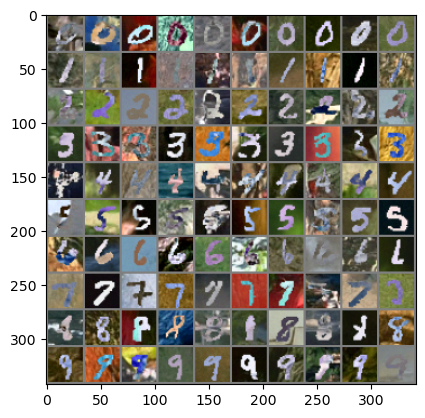

cuda:0


999it [00:11, 87.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


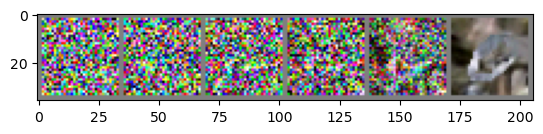

In [11]:
model = UNet_conditional(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("./diffusion_model.pt"))
diff = Diffusion()
diff.sample(model)
# diff.output(model)
diff.requiredImage(model)

In [13]:
# same_seeds(30)
model = UNet_conditional(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("./diffusion_model.pt"))
diff = Diffusion()
# diff.sample(model)
diff.output(model)
# diff.requiredImage(model)

cuda:0


In [15]:
!python3 digit_classifier.py --folder "/data/jhccc/dlcv/hw2-jhc659/DDPM/output"


model loaded from ./Classifier.pth
acc = 0.966 (correct/total = 966/1000)
